# Visualize TSE, R and S for brain data
While using the R and S values to define the synergy and redundancy dominance

In [10]:
import infotopo_no_prints
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import Bunch

In [189]:
# Define functions

# Normalize the first two columns individually for a given dataframe (range 0-1)
def normalize_columns(df):
    # Normalize first column (index 0)
    min_x, max_x = df.iloc[:, 0].min(), df.iloc[:, 0].max()
    df.iloc[:, 0] = (df.iloc[:, 0] - min_x) / (max_x - min_x) if max_x != min_x else 0
    
    # Normalize second column (index 1)
    min_y, max_y = df.iloc[:, 1].min(), df.iloc[:, 1].max()
    df.iloc[:, 1] = (df.iloc[:, 1] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    return df

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_dominance(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)
        #Ninfomut = coarse_grain_with_xgi(Ninfomut, 4)
        S_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value < 0)
        R_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value > 0)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    max_R = df_output.iloc[:, 0].max()
    max_S = df_output.iloc[:, 1].max()

    if max_S > 0:
        df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    if max_R > 0:
        df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)
        #Ninfomut = coarse_grain_with_xgi(Ninfomut, 4)
        MI_sum = sum(Ninfomut.values())
        TC_sum = sum(Nfree_energy.values())
        S_sum = -(TC_sum-MI_sum)/2
        R_sum = -(TC_sum+MI_sum)/2
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    max_R = df_output.iloc[:, 0].max()
    max_S = df_output.iloc[:, 1].max()

    if max_S > 0:
        df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    if max_R > 0:
        df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

In [178]:
# Import data
# Random timeseries
df_random = pd.read_csv("Data\\timeseries_test.txt", delim_whitespace=True)

# Brain data
df_brain = pd.read_csv("C:\\Users\\cyril\\Documents\\Personal\\Github\\PhD_1\\Data\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt", sep='\t', header=None, usecols=lambda col: col != 'Time')
df_brain = df_brain.transpose()

C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\1812602464.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_random = pd.read_csv("Data\\timeseries_test.txt", delim_whitespace=True)


In [137]:
# Set information extraction conditions
df = df_brain
window_size = 1000 #int(df.shape[0]/10)
window_step = 100 #int(df.shape[0]/100)
dimension_max = 4
dimension_tot = 8

#TSE_R_S_df_dominance = interactions_values_dominance(df, window_size, window_step, dimension_max, dimension_tot)
TSE_R_S_df_relative = interactions_values_relative(df, window_size, window_step, dimension_max, dimension_tot)

C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\1310878519.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


In [138]:
# Normalize the columns for the relative plot to improve visualization
normalized_TSE_R_S_df_relative = normalize_columns(TSE_R_S_df_relative)

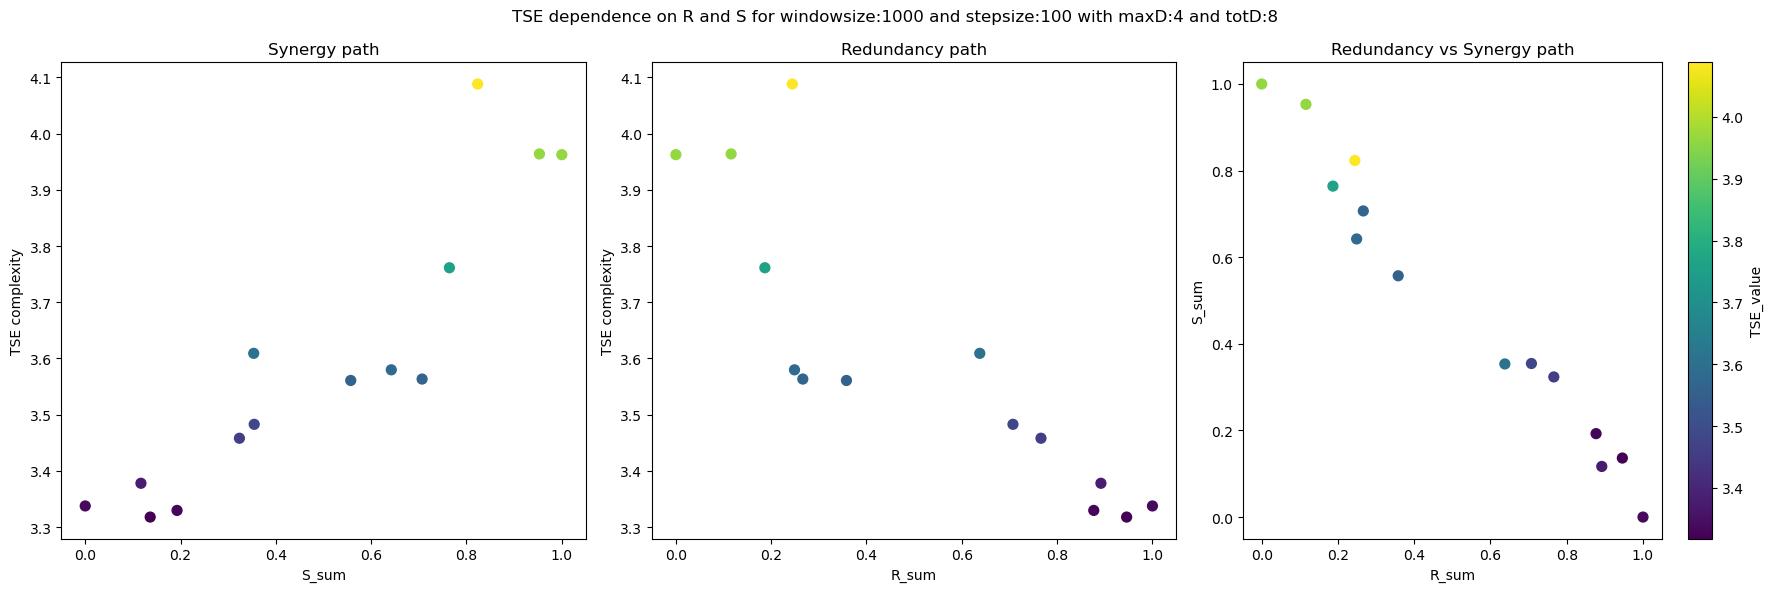

In [139]:
# Create a figure with 1 row and 3 columns for subplots
df = normalized_TSE_R_S_df_relative
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.scatter(df['S_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'TSE dependence on R and S for windowsize:{window_size} and stepsize:{window_step} with maxD:{dimension_max} and totD:{dimension_tot}')
plt.tight_layout()
plt.show()

Test on exchange rate timeseries data \
Expectation: change in synergy, redundancy and complexity as time increases due to globalisation

In [207]:
import pandas as pd
import gzip
import urllib.request

# URL of the dataset
url = "https://github.com/laiguokun/multivariate-time-series-data/raw/master/exchange_rate/exchange_rate.txt.gz"
file_path = "exchange_rate.txt.gz"

# Download the file
urllib.request.urlretrieve(url, file_path)

# Read the gzipped file into a pandas DataFrame
with gzip.open(file_path, 'rt') as f:
    df = pd.read_csv(f, sep=',', header=None)

In [208]:
window_size = 1000 #int(df.shape[0]/10)
window_step = 10 #int(df.shape[0]/100)
dimension_max = 4
dimension_tot = 8

TSE_R_S_df_relative = interactions_values_relative(df, window_size, window_step, dimension_max, dimension_tot)

normalized_TSE_R_S_df_relative = normalize_columns(TSE_R_S_df_relative)

C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\1310878519.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


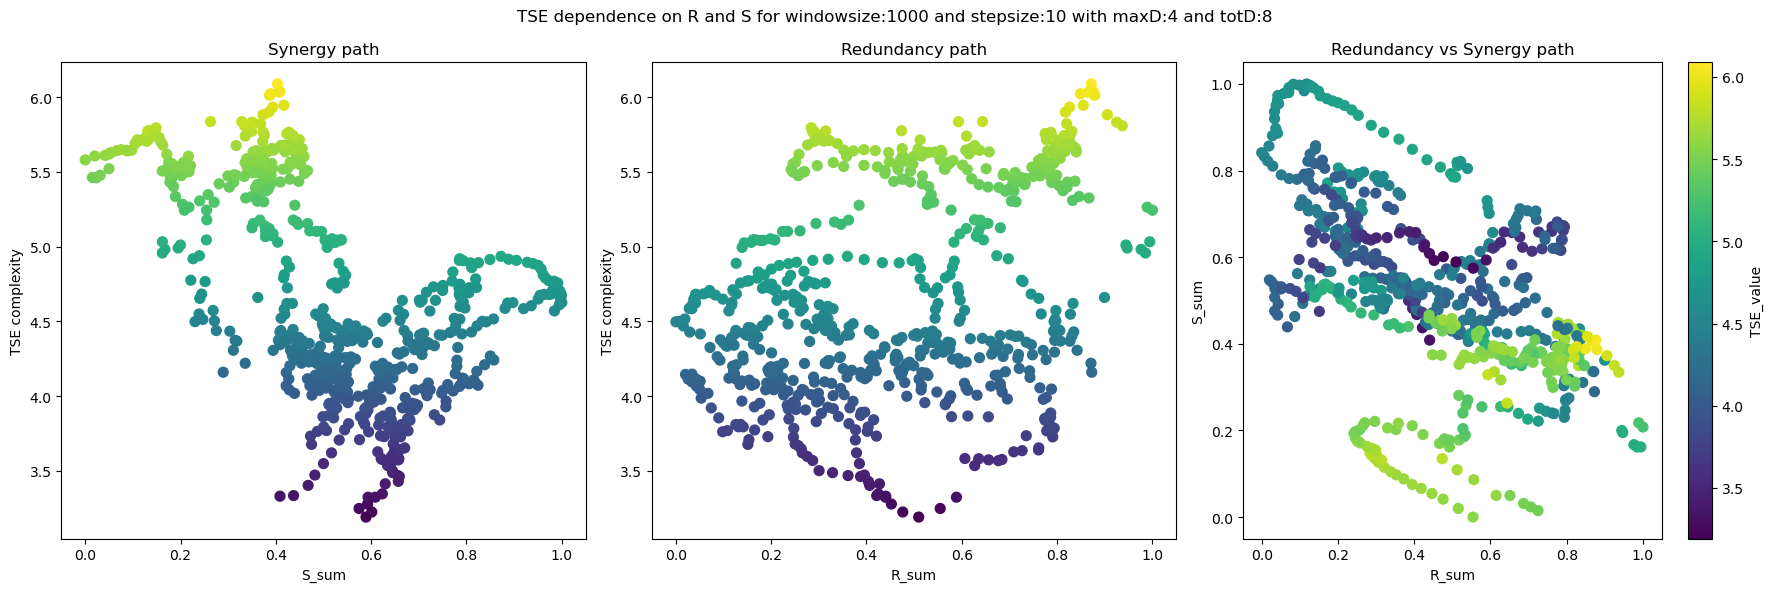

In [209]:
# Create a figure with 1 row and 3 columns for subplots
df = normalized_TSE_R_S_df_relative
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)
plt.scatter(df['S_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
# for i, (x, y) in enumerate(zip(df['S_sum'], df['TSE_value'])):
    # plt.text(x, y, f"t{i+1}", fontsize=12, ha='right')
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['TSE_value'])):
#    plt.text(x, y, f"t{i+1}", fontsize=12, ha='right')
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['S_sum'])):
#    plt.text(x, y, f"t{i+1}", fontsize=12, ha='right')
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'TSE dependence on R and S for windowsize:{window_size} and stepsize:{window_step} with maxD:{dimension_max} and totD:{dimension_tot}')
plt.tight_layout()
plt.show()


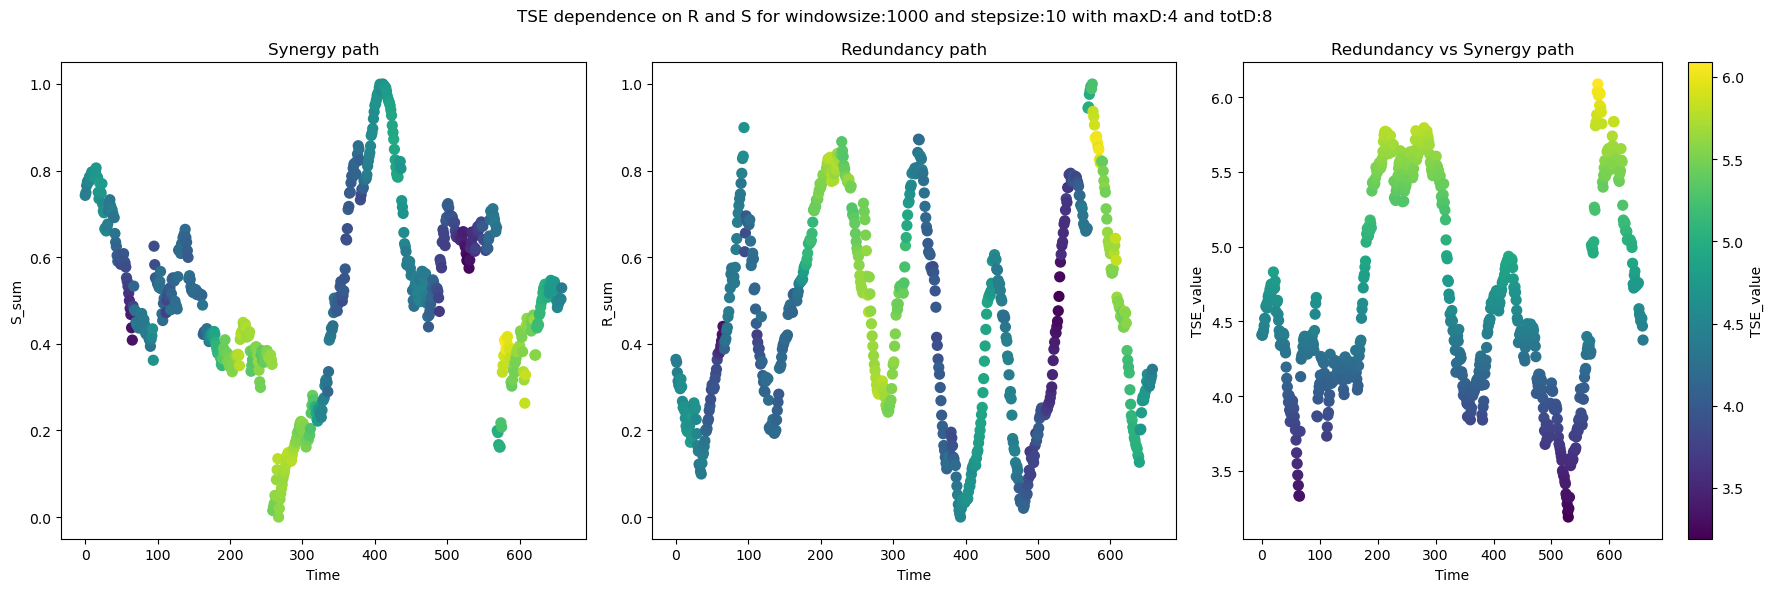

In [212]:
# Create a figure with 1 row and 3 columns for subplots
df = normalized_TSE_R_S_df_relative
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)
plt.scatter(df['S_sum'].index, df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
# for i, (x, y) in enumerate(zip(df['S_sum'], df['TSE_value'])):
    # plt.text(x, y, f"t{i+1}", fontsize=12, ha='right')
plt.xlabel('Time')
plt.ylabel('S_sum')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'].index, df['R_sum'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['TSE_value'])):
#    plt.text(x, y, f"t{i+1}", fontsize=12, ha='right')
plt.xlabel('Time')
plt.ylabel('R_sum')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['TSE_value'].index, df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['S_sum'])):
#    plt.text(x, y, f"t{i+1}", fontsize=12, ha='right')
plt.colorbar(label='TSE_value')
plt.xlabel('Time')
plt.ylabel('TSE_value')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'TSE dependence on R and S for windowsize:{window_size} and stepsize:{window_step} with maxD:{dimension_max} and totD:{dimension_tot}')
plt.tight_layout()
plt.show()


Test the oscillator dynamics

In [232]:
# Load oscillator system
df_oscillators = pd.read_csv("Data\\time_series_coupled_oscillator.txt", delim_whitespace=True)

C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\3474379605.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_oscillators = pd.read_csv("Data\\time_series_coupled_oscillator.txt", delim_whitespace=True)


In [233]:
window_size = 2000 #int(df.shape[0]/10)
window_step = 100 #int(df.shape[0]/100)
dimension_max = 4
dimension_tot = 8

TSE_R_S_df_relative = interactions_values_relative(df_oscillators, window_size, window_step, dimension_max, dimension_tot)

normalized_TSE_R_S_df_relative = normalize_columns(TSE_R_S_df_relative)

C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\1310878519.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


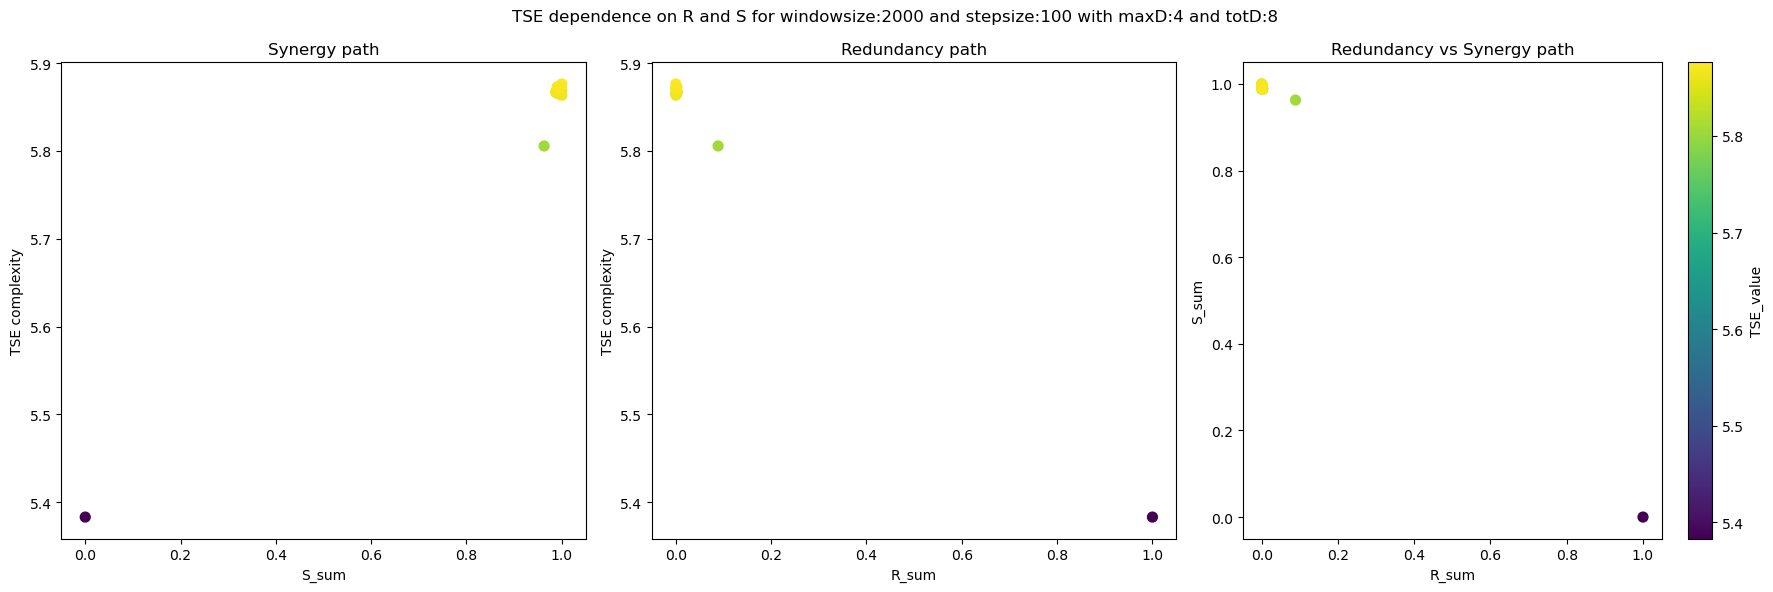

In [234]:
# Create a figure with 1 row and 3 columns for subplots
df = normalized_TSE_R_S_df_relative
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)
plt.scatter(df['S_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'TSE dependence on R and S for windowsize:{window_size} and stepsize:{window_step} with maxD:{dimension_max} and totD:{dimension_tot}')
plt.tight_layout()
plt.show()


Render animation of increasing windowsize

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\1310878519.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)
C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\1310878519.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)
C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\1310878519.py:147: FutureWarning: T

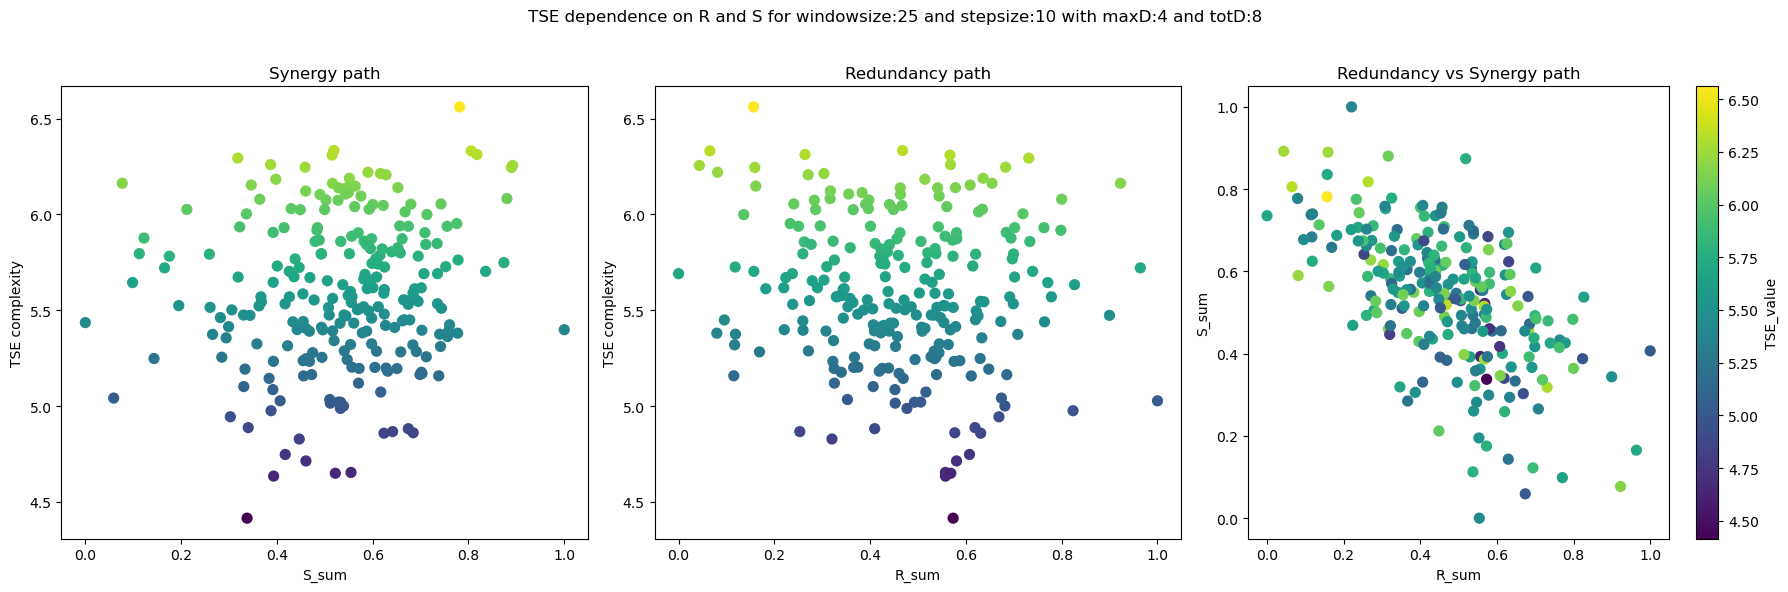

In [140]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np

# Assuming you have already imported or defined the functions like `interactions_values_relative` and `normalize_columns`

# Initialize the figure for animation
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Create the colorbar only once (before the animation starts)
colorbar = None  # Placeholder for colorbar, will be created once

def update_plot(frame):
    # Set information extraction conditions
    window_size = frame  # window_size will change for each frame
    window_step = 10
    dimension_max = 4
    dimension_tot = 8

    # Call your function to get the data (adjust these functions according to your needs)
    TSE_R_S_df_relative = interactions_values_relative(df_brain, window_size, window_step, dimension_max, dimension_tot)
    normalized_TSE_R_S_df_relative = normalize_columns(TSE_R_S_df_relative)

    # First subplot for Synergy path
    axs[0].cla()  # Clear previous plot
    axs[0].scatter(normalized_TSE_R_S_df_relative['S_sum'], normalized_TSE_R_S_df_relative['TSE_value'], 
                   c=normalized_TSE_R_S_df_relative['TSE_value'], cmap='viridis', s=50)
    axs[0].set_xlabel('S_sum')
    axs[0].set_ylabel('TSE complexity')
    axs[0].set_title('Synergy path')

    # Second subplot for Redundancy path
    axs[1].cla()  # Clear previous plot
    axs[1].scatter(normalized_TSE_R_S_df_relative['R_sum'], normalized_TSE_R_S_df_relative['TSE_value'], 
                   c=normalized_TSE_R_S_df_relative['TSE_value'], cmap='viridis', s=50)
    axs[1].set_xlabel('R_sum')
    axs[1].set_ylabel('TSE complexity')
    axs[1].set_title('Redundancy path')

    # Third subplot for Redundancy vs Synergy path
    axs[2].cla()  # Clear previous plot
    sc = axs[2].scatter(normalized_TSE_R_S_df_relative['R_sum'], normalized_TSE_R_S_df_relative['S_sum'], 
                        c=normalized_TSE_R_S_df_relative['TSE_value'], cmap='viridis', s=50)
    axs[2].set_xlabel('R_sum')
    axs[2].set_ylabel('S_sum')
    axs[2].set_title('Redundancy vs Synergy path')

    # Add the colorbar only in the first frame (to avoid multiple colorbars)
    global colorbar
    if colorbar is None:
        colorbar = plt.colorbar(sc, ax=axs[2], label='TSE_value')

    # Adjust layout to avoid overlap
    plt.suptitle(f'TSE dependence on R and S for windowsize:{window_size} and stepsize:{window_step} with maxD:{dimension_max} and totD:{dimension_tot}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to make room for the suptitle

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=[25, 50, 100, 200, 400, 600, 800, 1000, 1300, 1600], repeat=False)

# Save the animation as a GIF
ani.save('TSE_dependency_animation.gif', writer='imagemagick', fps=1)
